In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import sys
sys.path.append('../..')

from importlib import reload
import sf_lib, sf_lib.helpers
reload(sf_lib.helpers)
from sf_lib.helpers import (
    get_cols,
    get_column_names,
    get_P_i,
    fleiss_kappa
)

%matplotlib inline

In [2]:
catalogue_targets = np.loadtxt('../../catalogue/sf_catalogue_targets.txt', dtype='str')
object_info = pd.read_csv('../../catalogue/sf_spacefluff_object_data.csv', comment="#")

In [3]:
# df_votes.json is created in ./df_stacked.ipynb. 
#  Make sure to re-run that whenever we change something, 
#   otherwise we'll be working with stale data in this notebook
df_votes = pd.read_json('df_votes.json')
df = pd.read_json('df_stacked.json')

In [4]:
workflows = df['workflow_name'].unique().tolist()
print(workflows)

hc = df.query('workflow_name == @workflows[0]')
classify = df.query('workflow_name == @workflows[1]')
onthego = df.query('workflow_name == @workflows[2]')

['Classify! Hardcore edition', 'Classify!', 'Classify on the go!']


---

In [5]:
# @todo: synchronize xlim and ylim based on min and max of whole dataframe

def plot_phot(dfs, labels, colors=None, alphas=None, sizes=None, title=None, savepath=None):
    fig, fr = plt.subplots(1,4, figsize=(17,4.5))

    if not sizes:
        sizes = [8 for i in range(len(dfs))]
    
    
    for idx, df in enumerate(dfs):
        r, g, mue_r, C = get_cols(df, ['r', 'g', 'mue_r', 'C'])

        if not alphas:
            alpha = 0.4
        else:
            alpha = alphas[idx]
        kw = dict(s=sizes[idx], alpha=alpha, label=labels[idx])
        
        if colors:
            kw['color'] = colors[idx]
        else:
            kw['color'] = None

        fr[0].scatter(g-r, mue_r, **kw)
        fr[1].scatter(r, mue_r, **kw)
        fr[2].scatter(r, g-r, **kw)
        fr[3].scatter(r, C, **kw)

        fr[3].update(dict(
            ylim=(0, np.max(df_votes['C'])+0.4)
        ))

        fr[0].set_xlabel(r"$g'-r'$ [mag]")
        fr[0].set_xlim([np.min(df_votes['g']-df_votes['r'])-0.2, np.max(df_votes['g']-df_votes['r'])+0.2])

        for i in range(2):
            fr[i].set_ylim(np.min(df_votes['mue_r'])+2.5, np.max(df_votes['mue_r']))
            fr[i].set_ylabel(r'$\mu_{e,r}$ [mag arcsec-2]')
            fr[i].set_ylim(fr[i].get_ylim()[::-1])

        for i in range(1, 4):
            fr[i].set_xlabel(r"$r'$ [mag]")
            fr[i].set_xlim(np.min(df_votes['r'])-1, np.max(df_votes['r'])+1)

        fr[2].set_ylabel(r"$g'-r' [mag]$")
        fr[3].set_ylabel('$C$')

    for i in range(4):
        fr[i].grid(alpha=0.3, which='both')
        fr[i].legend()

    if title:
        fig.suptitle(title)
    fig.tight_layout()
    
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
        
    plt.show()

In [6]:
def plot_distr(frames, labl, colors=None, savepath=None):
    fig, fr = plt.subplots(1,4, figsize=(17,3.5))

    for idx, frame in enumerate(frames):
        kw = dict(histtype='step', facecolor='none', lw=2, density=True, label=labl[idx])
        
        if colors:
            kw['edgecolor'] = colors[idx]

        fr[0].hist(frame['g']-frame['r'], **kw)
        fr[1].hist(frame['mue_r'], **kw)
        fr[3].hist(frame['Reff'], **kw)
        fr[2].hist(frame['C'], **kw)

    labels = [r"$g'-r' [mag]$", r'$\mu_{e,r}$ [mag arcsec-2]', r'$R_{eff}$ [kpc]', '$C$']
    for i in range(4):
        fr[i].update(dict(
            xlabel=labels[i]
        ))
        fr[i].grid(alpha=0.3)
        fr[i].legend()
    fr[0].update(dict(ylabel='normalized count'))
    fig.tight_layout()
    
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()
    

### Make plots like Venhola2018 for various data subsets:

In [7]:
t0cols = get_column_names('T0', df_votes)

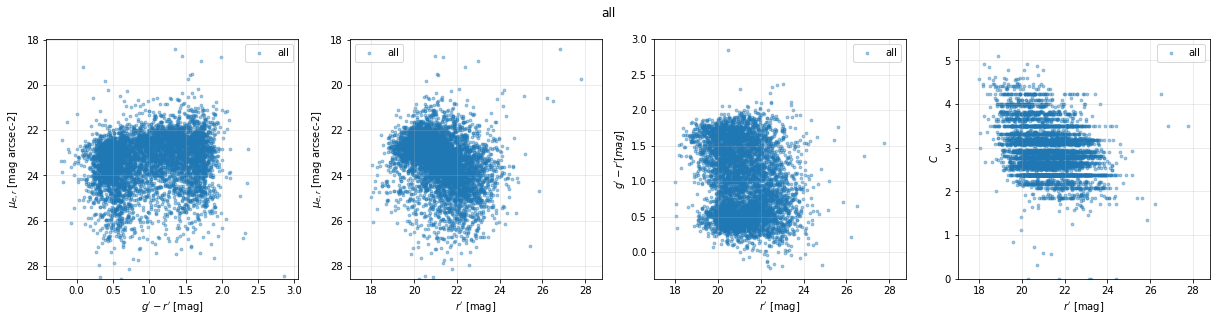

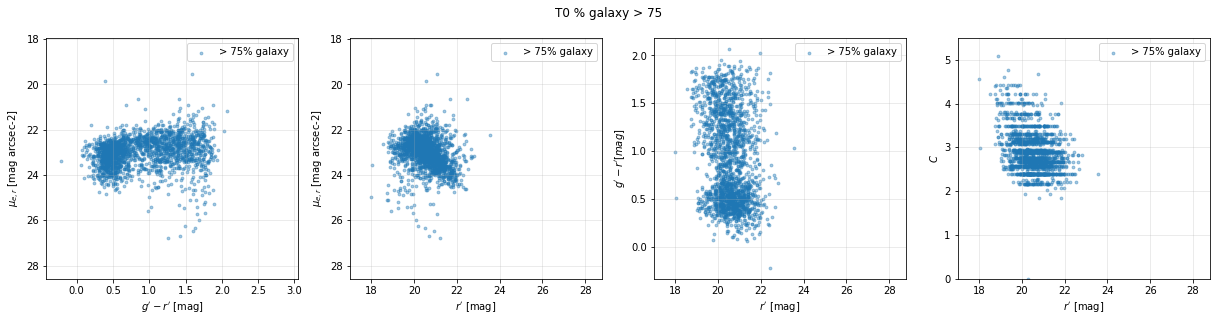

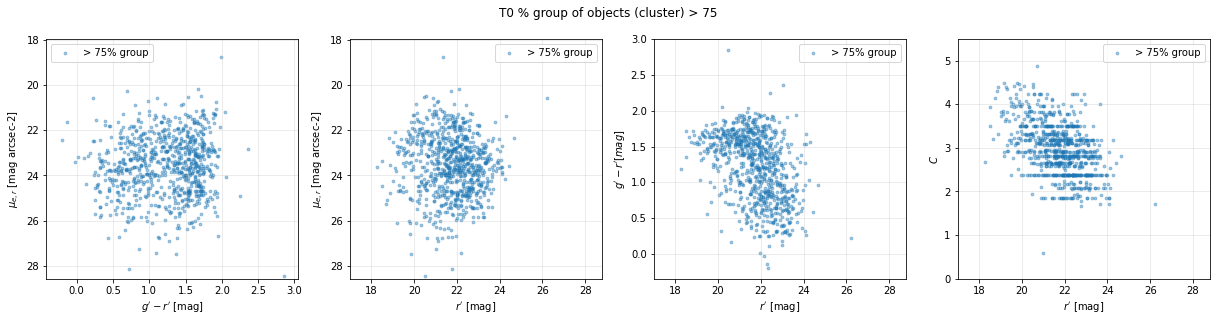

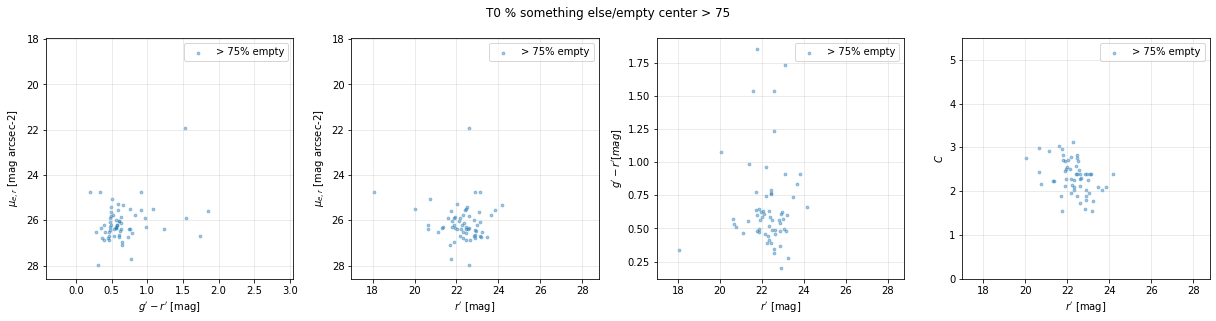

In [8]:
plot_phot([df_votes], ['all'], title='all')
labels = ['galaxy', 'group', 'empty']
for idx, ans in enumerate(t0cols[1:]):
    ans_str = '`{}`'.format(ans)
    plot_phot(
        [df_votes[df_votes[ans] > 75]], 
        ['> 75% {}'.format(labels[idx])], 
        title='{} > 75'.format(ans),
        colors=None
    )

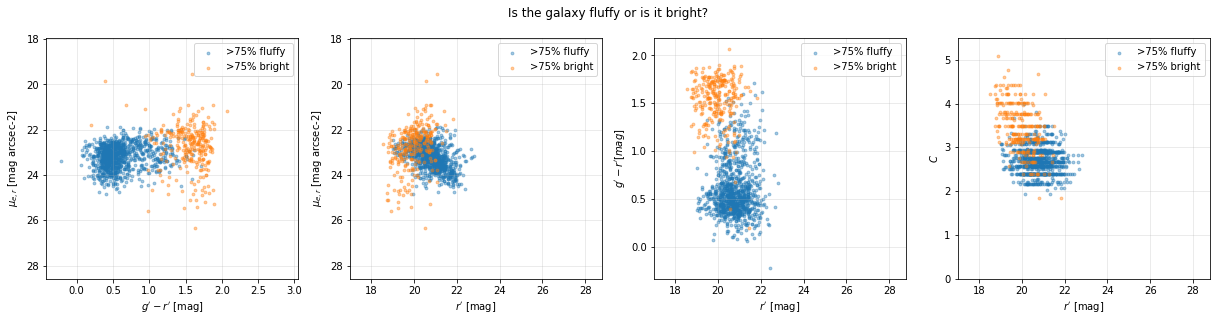

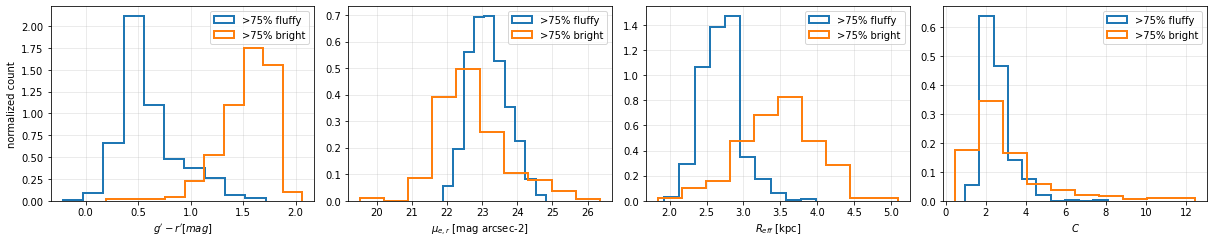

In [9]:
frames =[
    df_votes.query("`T0 % galaxy` > 75 & `T1 % fluffy` > 75"),
    df_votes.query("`T0 % galaxy` > 75 & `T1 % bright` > 75")
]
labl = ['>75% fluffy', '>75% bright']
plot_phot(frames, labl, title='Is the galaxy fluffy or is it bright?')
plot_distr(frames, labl)

In [10]:
t2cols = get_column_names('T2', df_votes); t2cols

['T2', 'T2 % impossible to say', 'T2 % white/blue', 'T2 % red/yellow']

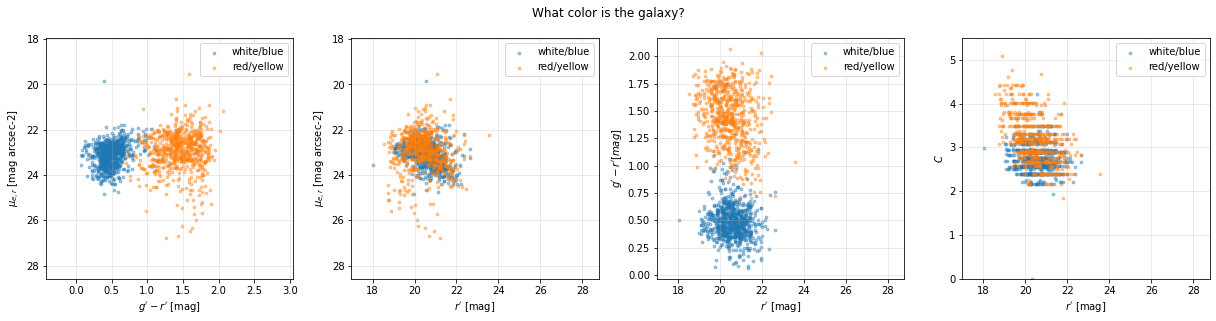

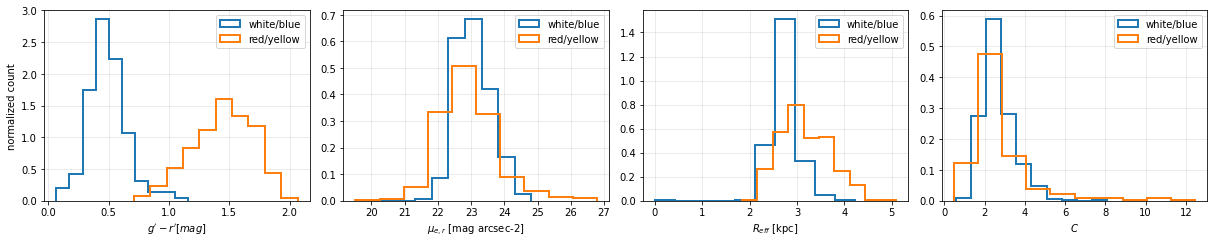

In [11]:
frames =  [
    df_votes.query("`T0 % galaxy` > 75 & `T2 % white/blue` > 75"),
    df_votes.query("`T0 % galaxy` > 75 & `T2 % red/yellow` > 75")
]
labl = ['white/blue', 'red/yellow']
plot_phot(frames, labl, title='What color is the galaxy?')

plot_distr(frames,labl)

In [12]:
t3cols = get_column_names('T3', df_votes); t3cols

['T3', 'T3 % no/unsure', 'T3 % yes, a bright point', 'T3 % yes, a bulge']

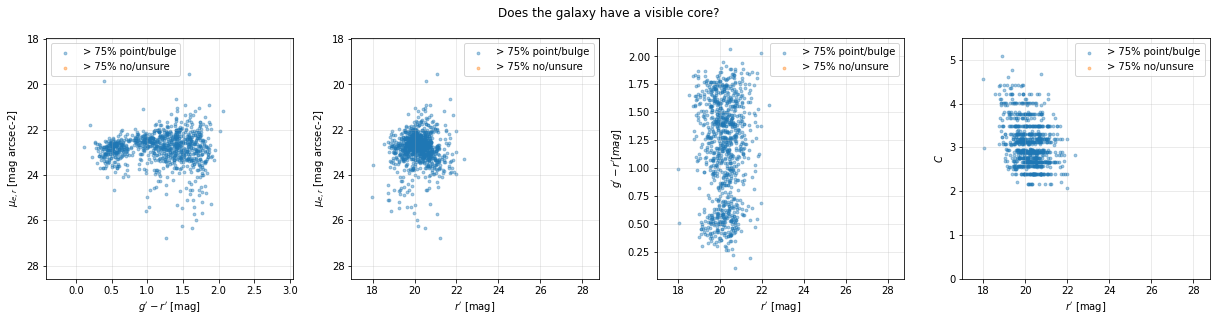

c:\users\christiaan\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\users\christiaan\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\users\christiaan\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\users\christiaan\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


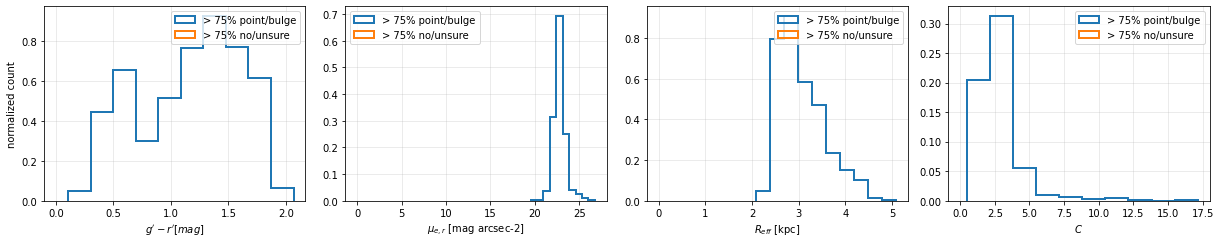

In [13]:
frames = [
    df_votes.query("`T0 % galaxy` > 75 & `T3 % yes, a bright point` + `T3 % yes, a bulge` > 75"),
    df_votes.query("`T0 % galaxy` > 75 & `T3 % no/unsure` > 75")
]
labl = ['> 75% point/bulge', '> 75% no/unsure']
plot_phot(frames, labl, title='Does the galaxy have a visible core?')
plot_distr(frames, labl)

In [14]:
t5cols = get_column_names('T5', df_votes); t5cols

['T5',
 'T5 % smooth and fuzzy',
 'T5 % smooth and dense',
 'T5 % clumpy and/or featured']

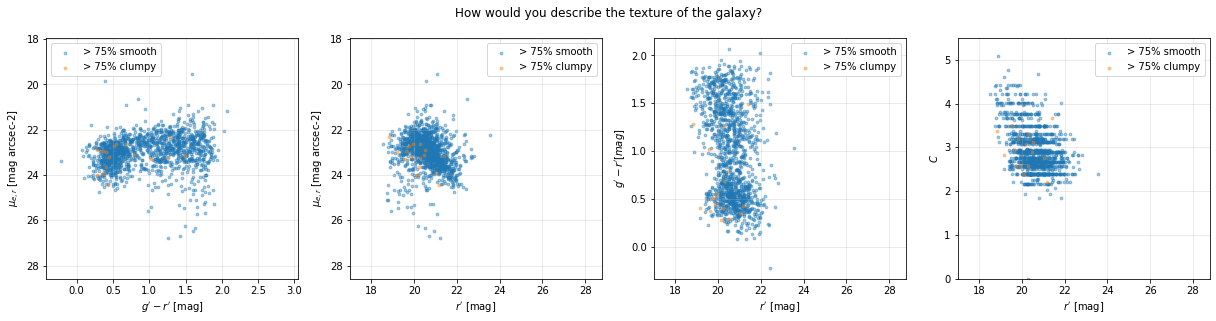

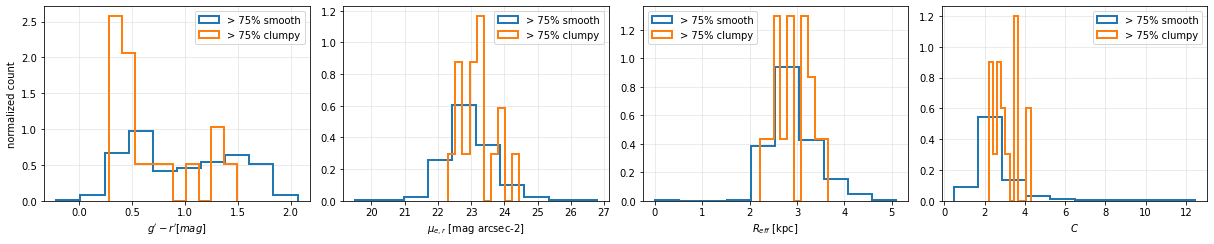

In [15]:
frames = [
    df_votes.query("`T0 % galaxy` > 75 & `T5 % smooth and fuzzy` + `T5 % smooth and dense` > 75"),
    df_votes.query("`T0 % galaxy` > 75 & `T5 % clumpy and/or featured` > 75")
]
labl = ['> 75% smooth', '> 75% clumpy']
plot_phot(frames, labl, title='How would you describe the texture of the galaxy?')
plot_distr(frames, labl)

### Following up on the plots above: find correlation between color and fluffy/bright votes:

In [16]:
gal = df_votes.query("`T0 % galaxy` > 75")
fluf = gal.query("`T1 % fluffy` > 75")
bright = gal.query("`T1 % bright` > 75")
other_gal = gal.query("`T1 % fluffy` <= 75 & `T1 % bright` <= 75")

In [17]:
gal.shape[0], fluf.shape[0], bright.shape[0], other_gal.shape[0]

(1936, 1006, 280, 650)

In [18]:
g_fluf, r_fluf = fluf['g'], fluf['r']

... not sure how I want to compare these, exactly

## Plot vote distributions for objects without properties:

In [19]:
no_props = df_votes.query('RA.isnull()')

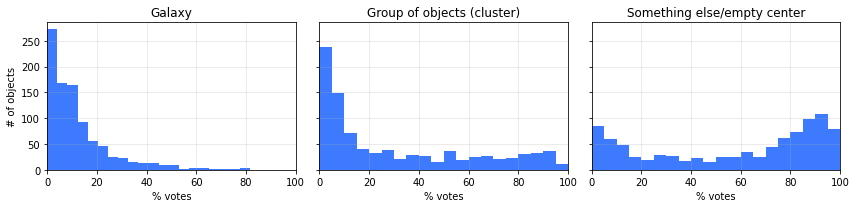

In [20]:
fig, fr = plt.subplots(1,3, figsize=(12,3), sharey=True)

labels = ['Galaxy', 'Group of objects (cluster)', 'Something else/empty center']
for i, ans in enumerate(t0cols[1:]):
    fr[i].hist(no_props[ans], density=False, bins=20, color='xkcd:lightish blue')
    fr[i].update(dict(
        xlim=[0,100],
        title=labels[i],
        xlabel="% votes",
    ))
    fr[i].grid(alpha=0.3)
        
fr[0].update(dict(ylabel="# of objects"))
fig.tight_layout()

plt.savefig('no props - votes.png', dpi=450, bbox_inches='tight')
plt.show()

In [21]:
no_props.shape[0], no_props.query('`T0 % galaxy` > 50').shape[0], no_props.query('`T0 % something else/empty center` > 50').shape[0]

(922, 19, 569)

We see that the vast majority of objects without photometric properties, get almost no votes for 'galaxy'.

### Compare votes to `ground truth`

In [22]:
# first assign the targets to a dataframe to save typing work
incatalogue = df_votes.query('name.isin(@catalogue_targets)')
# incatalogue = incatalogue.query('C > -1')

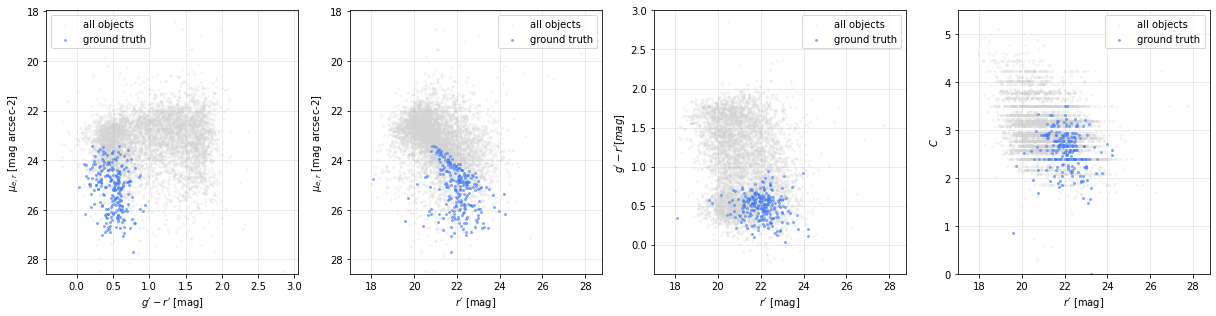

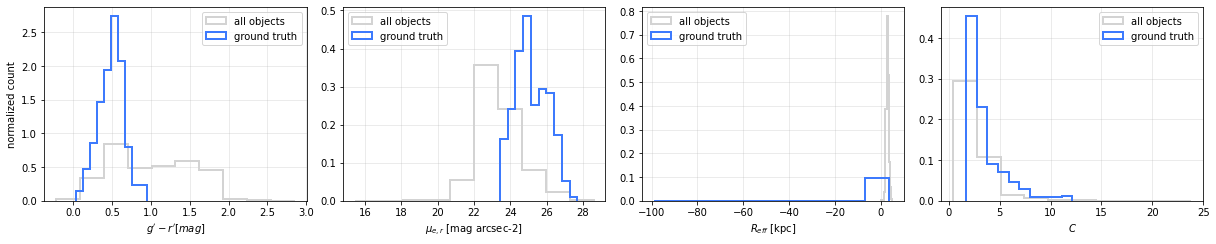

In [23]:
# plot properties of (1) all objects in SF and (2) only the ground truth objects
frames =[
    df_votes.query('C > -1'),
    incatalogue,
]
labl = [
    'all objects',
    'ground truth', 
]
c = ['lightgrey', 'xkcd:lightish blue']

kw = dict(colors=c, alphas=[0.18, 0.5], sizes=[4, 4])
plot_phot(frames, labl, **kw, savepath='./plots/ground truth/props.png')
plot_distr(frames, labl, colors=c, savepath='./plots/ground truth/props-hist.png')

In [24]:
from itertools import combinations

In [25]:
comb_idc = list(combinations(list(range(3)), r=2))

In [26]:
t0cols[1:]

['T0 % galaxy',
 'T0 % group of objects (cluster)',
 'T0 % something else/empty center']

In [27]:
fluf = df_votes.query("`T0 % galaxy` > 75 & `T1 % fluffy` > 50")

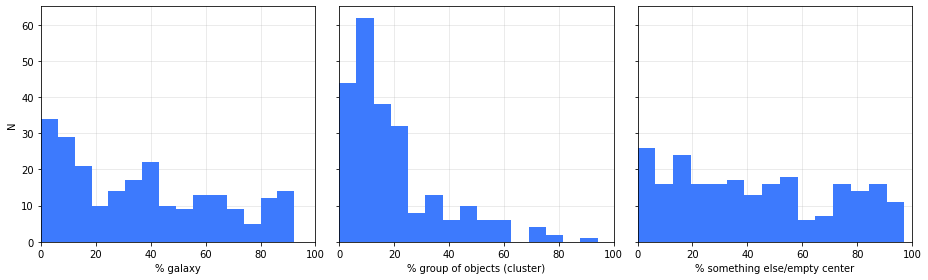

In [28]:
fig, fr = plt.subplots(1,3,figsize=(13,4), sharey=True)

for i, col in enumerate(t0cols[1:]):
    kw = dict(zorder=2, bins=15, facecolor='xkcd:lightish blue')
    fr[i].grid(alpha=0.3, zorder=0)    
    fr[i].hist(incatalogue[col], **kw)
    
    fr[i].update(dict(
        xlabel=col[3:],
        xlim=[0,100]
    ))

fr[0].update(dict(ylabel='N'))
# fig.suptitle('Vote distributions for \'ground truth\' objects')
fig.tight_layout()

plt.savefig('./plots/ground truth/votes.png', dpi=150, bbox_inches='tight')

In [29]:
# 'group of objects' > 50% for likely ground truth objects
print(
    incatalogue[incatalogue[t0cols[2]] >= 50].shape[0] / incatalogue.shape[0]*100
)

# 'group of objects' > 50% for overall data set
print(
    df_votes[df_votes[t0cols[2]] >= 50].shape[0] / df_votes.shape[0]*100
)

8.620689655172415
33.715812637535365


In [30]:
# N objects in catalogue
incatalogue.shape[0]

232

In [31]:
# N objects with >= i% votes for galaxy
[incatalogue.query('`T0 % galaxy` >= @i').shape[0] for i in [0, 25, 50, 75, 100] ]

[232, 138, 75, 30, 0]

## Vote distributions for various subsets of the complete dataset
<div style="color: orangered;">
    Belongs in thesis section <em>"the numbers"</em>
</div>

In [32]:
frames = [df_votes, incatalogue, df_votes.query('RA.isnull()'), df_votes.query('~RA.isnull()')]
titles = ['All objects', 'Objects in catalogue', 'Objects without properties', 'Objects with properties']

objs = []
for frame, name in zip(frames, titles):
    N = frame.shape[0]
    
    obj = dict(
        object_selection=name,
    )
    
    for answer in t0cols[1:]:
        for threshold in [50,75]:
            obj['{} (>={}%)'.format(' '.join(answer.split(' ')[2:]), threshold)] = '{}%'.format(round(100*frame[frame[answer] >= threshold].shape[0]/N, 1))
    objs.append(obj)
    
pd.DataFrame(objs)

,object_selection,galaxy (>=50%),galaxy (>=75%),group of objects (cluster) (>=50%),group of objects (cluster) (>=75%),something else/empty center (>=50%),something else/empty center (>=75%)
0,All objects,48.8%,31.0%,33.7%,15.5%,11.8%,7.7%
1,Objects in catalogue,32.3%,12.9%,8.6%,1.3%,39.2%,19.4%
2,Objects without properties,2.6%,0.4%,28.3%,14.4%,62.4%,45.9%
3,Objects with properties,56.6%,36.2%,34.6%,15.7%,3.2%,1.2%


## Fleiss' $\kappa$

see https://en.wikipedia.org/wiki/Fleiss%27_kappa

| n_ij | 1 | 2 | 3 | P_i |
|--|--|--|--|--|
| 1 | q | x | x |  a |
| 2 | x | x | x |  b |
| 3 | x | x | x |  c |
|---|
| Total | y | y | y
p_j | z | z | z |

Left 1, 2, 3 each represent an object (so each row corresponds to 1 object)

Top 1, 2, 3 each represent a category (for us, 'galaxy', etc, so each column represents a category)

Every table entry n_ij (e.g. n_11, with value `q` above) represents the number of votes that object got for that category.

p_j,1 = sum(n_j, 1)/N, e.g. the sum of all values in column '1' divided by the total number of classifications (in the table above, N = 3x3 = 9)

In [33]:
answers = df['T0'].unique()  # categories

In [34]:
q = df_votes.query('RA.isnull()')['name']

for task in ['T0']:
    print(
        fleiss_kappa(df, df_votes, task), \
        fleiss_kappa(df.query('Filename.isin(@catalogue_targets)'), incatalogue, task), \
        fleiss_kappa(df.query('Filename.isin(@q)'), df_votes.query('name.isin(@q)'), task), \
        fleiss_kappa(df.query('~Filename.isin(@q)'), df_votes.query('~name.isin(@q)'), task)
    )

0.6664100600648118 0.5667051671858755 0.6877886162364092 0.6627480188853848


We see that $\kappa$ is actually lower for the catalogue objects, indicating a lower level of agreement among users for these objects than for the overall dataset. For objects without properties, $\kappa$ is slightly higher.

## Power users...

In [35]:
clas_in_catalogue = df.query('Filename.isin(@catalogue_targets)')

In [36]:
gr_user = clas_in_catalogue.groupby('user_name')

In [37]:
hash_all = {}

for name, group in gr_user:
    count = group.shape[0]
    hash_all[name] = {'total': count, 'galaxy': 0}

In [38]:
for name, group in clas_in_catalogue.query("T0 == 'galaxy'").groupby('user_name'):
    hash_all[name]['galaxy'] = group.shape[0]

In [39]:
for user, val in list(hash_all.items()):
    hash_all[user]['percentage'] = val.get('galaxy')/val.get('total')

In [40]:
total, percentage = np.array([(u['total'], u['percentage']) for u in list(hash_all.values())]).T

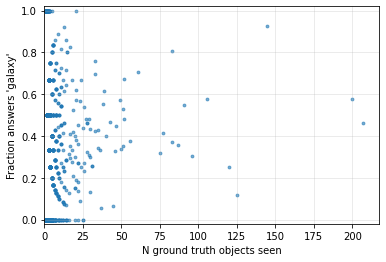

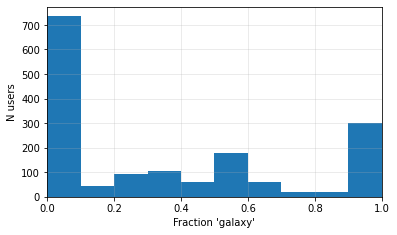

In [41]:
fig, fr = plt.subplots(figsize=(6,4))

fr.scatter(total, percentage, s=8, alpha=0.6)

fr.update(dict(xlim=0,ylim=[-0.02,1.02], xlabel='N ground truth objects seen', ylabel="Fraction answers 'galaxy'"))
fr.grid(alpha=0.3)

fig, fr = plt.subplots(figsize=(6,3.5))
fr.hist(percentage)
fr.update(dict(xlim=[0,1], xlabel="Fraction 'galaxy'", ylabel='N users'))
fr.grid(alpha=0.3)

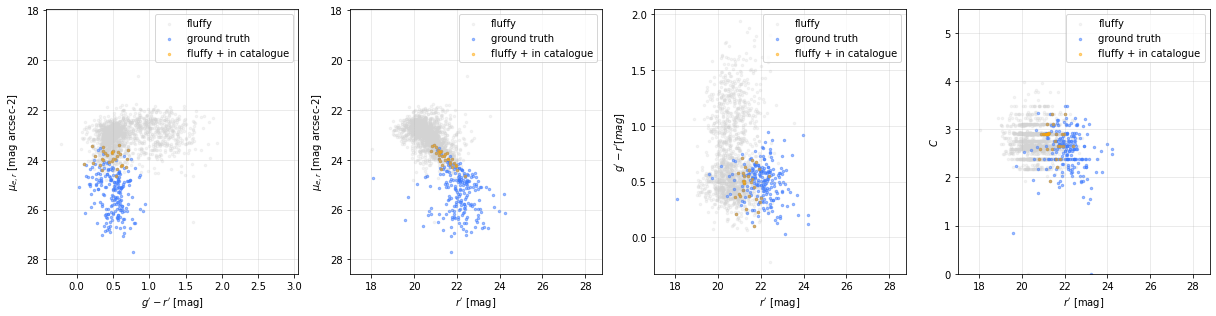

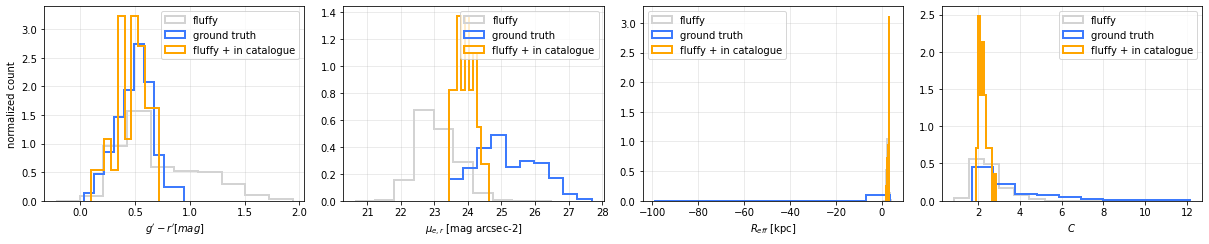

In [42]:
# plot properties of (1) all objects in SF and (2) only the ground truth objects
frames =[
    df_votes.query('`T0 % galaxy` > 75 & `T1 % fluffy` > 50'),
    
    incatalogue,
    incatalogue.query('`T0 % galaxy` > 75 & `T1 % fluffy` > 50')
]
labl = [
    'fluffy',
    'ground truth', 
    'fluffy + in catalogue',
]
c = ['lightgrey', 'xkcd:lightish blue', 'orange']

kw = dict(alphas=[0.25, 0.5,0.5], sizes=[6 for i in range(len(frames))], colors=c)
plot_phot(frames, labl, **kw)
plot_distr(frames, labl, colors=c)

## Compare catalogue objects that DO get voted fluffy vs those that get voted BRIGHT/else

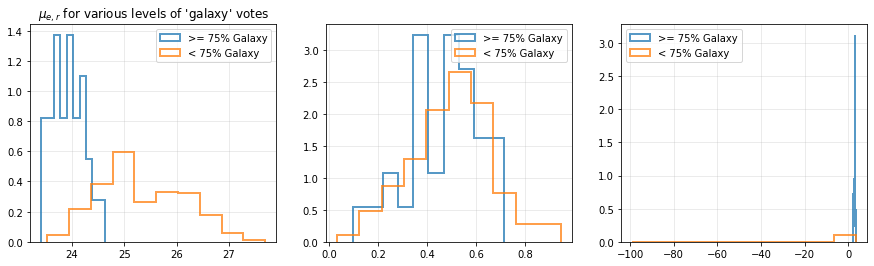

In [43]:
fig, fr = plt.subplots(1,3, figsize=(15,4))

frames = [
    incatalogue.query('`T0 % galaxy` >= 75'),
    incatalogue.query('`T0 % galaxy` < 75')
]

labels = [">= 75% Galaxy", '< 75% Galaxy']

kw = dict(histtype='step', facecolor='none', alpha=0.75, lw=2, density=True, bins=10)
for i, frame in enumerate(frames):
    kw['label'] = labels[i]
    fr[0].hist(frame['mue_r'], **kw)
    fr[0].update(dict(title=r"$\mu_{e,r}$ for various levels of 'galaxy' votes"))
    fr[0].invert_xaxis()
    
    fr[1].hist(frame['g']-frame['r'], **kw)
    
    fr[2].hist(frame['C'], **kw)
    

for i in range(len(fr)):
    fr[i].legend()
    fr[i].grid(alpha=0.3)

In [193]:
def plot_image_grid(input_df, rows, cols, title=None, savepath=None):
    size=3*rows*cols
    fig, fr = plt.subplots(rows,cols, figsize=(size, size))
    fr = np.ravel(fr)

    idc = np.random.randint(0, input_df.shape[0], rows*cols)
    for i, name in enumerate(input_df['name'].iloc[idc]):
        object_name = name
        path = '../image/thumbnails/{}_insp.png'.format(object_name)
        image = Image.open(path)
        fr[i].imshow(image)
        fr[i].set_title(object_name)
        fr[i].set_axis_off()

    if title:
        fig.suptitle(title)
    fig.tight_layout()
    
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()

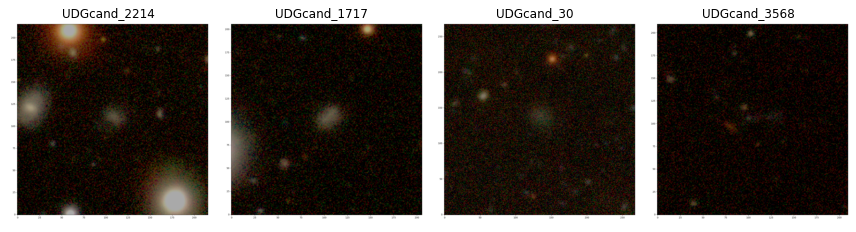

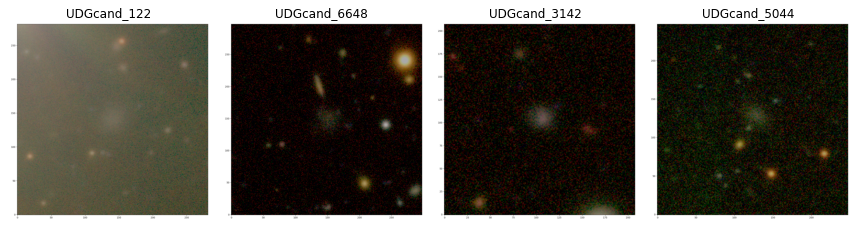

In [45]:
plot_image_grid(incatalogue, 1,4)
plot_image_grid(incatalogue, 1,4)

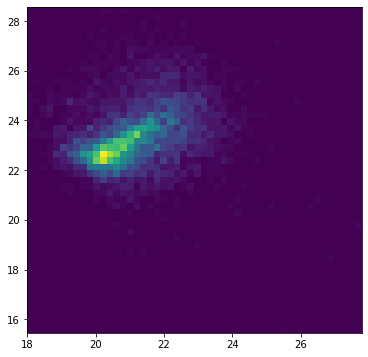

In [46]:
# fig, fr = plt.subplots(figsize=(6,6))
# fr.hist2d(incatalogue['r'], incatalogue['mue_r'], bins=15)
# plt.show()

t = df_votes.query('~RA.isnull()')
fig, fr = plt.subplots(figsize=(6,6))
fr.hist2d(t['r'], t['mue_r'], bins=50)
plt.show()

---

In [47]:
incatalogue.shape[0]

232

In [48]:
for threshold in [25, 50, 75]:
    N = incatalogue.shape[0]
    count = incatalogue.query('`T0 % galaxy` >= @threshold').shape[0]
    print(count, count/N)

138 0.5948275862068966
75 0.3232758620689655
30 0.12931034482758622


In [49]:
gal_cat = incatalogue.query("`T0 % galaxy` > 75")
gal_cat['T1 % fluffy']

t1cols = get_column_names('T1', df_votes)
gal_cat[[*t0cols, *t1cols]]

fluf_percentages = []
for count, fluf_count in zip(gal_cat['T1'].apply(lambda x: sum(list(x.values()))).tolist(), gal_cat['T1'].apply(lambda x: x.get('Fluffy'))):
    fluf_pct = round(100*fluf_count/count, 1)
    fluf_percentages.append(fluf_pct)
#     print(fluf_count, count, fluf_pct)

print(min(fluf_percentages))

91.3


In [50]:
gal = df_votes.query("`T0 % galaxy` >= 75")
for i in [50, 75, 90]:
    print(gal.query('`T1 % fluffy` >= @i').shape[0]/gal.shape[0])

0.7394830207805373
0.5321844906234161
0.277749619868221


### Properties vs. galaxy votes

#### Plot properties, use colorbar to indicate galaxy vote percentage:

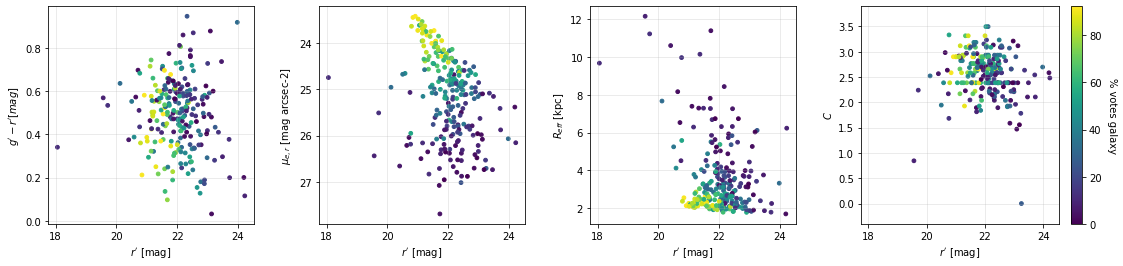

In [51]:
fig, fr = plt.subplots(1,4, figsize=(19,4), gridspec_kw=dict(wspace=0.3, width_ratios=[5,5,5,6]))

t = incatalogue
kw = dict(
    c=t['T0 % galaxy'],
    s=14
)

sc1 = fr[0].scatter(t['r'], t['g']-t['r'], **kw); fr[0].update(dict(ylabel=r"$g'-r' [mag]$"))
fr[1].scatter(t['r'], t['mue_r'], **kw); fr[1].update(dict(ylabel=r"$\mu_{e,r}$ [mag arcsec-2]"))
fr[2].scatter(t['r'], t['Reff'], **kw); fr[2].update(dict(ylabel="$R_{eff}$ [kpc]"))
fr[3].scatter(t['r'], t['C'], **kw); fr[3].update(dict(ylabel="$C$"))

fr[3].update(dict(ylim=[np.min(t.query('C > -1')['C'])-0.4, np.max(t['C'])+0.4]))

fr[1].invert_yaxis()

for i in range(len(fr)):
    fr[i].grid(alpha=0.3)
    fr[i].update(dict(
        xlabel=r"$r'$ [mag]"
    ))

cb = fig.colorbar(sc1)
cb.set_label("% votes galaxy", rotation=-90, labelpad=15)

plt.savefig('./plots/ground truth/props vs. galaxy percentage.png', dpi=200, bbox_inches='tight')
plt.show()

#### Plot surface brightness against galaxy vote percentage:

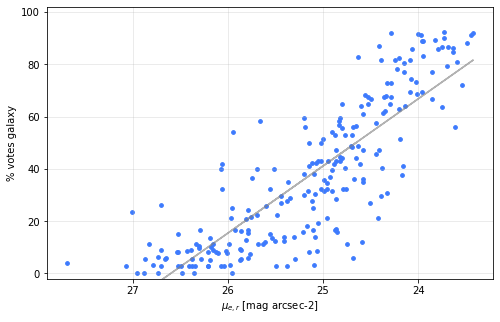

In [52]:
fig, fr = plt.subplots(figsize=(8,5))

kw['c'] = 'xkcd:lightish blue'
sc = fr.scatter(t['mue_r'], t['T0 % galaxy'], **kw)

p, res, _, _, _ = np.polyfit(t['mue_r'], t['T0 % galaxy'], 1, full=True)
ys = np.polyval(p, t['mue_r'])

fr.plot(t['mue_r'], ys, c='grey', alpha=0.6)
fr.grid(alpha=0.3)
fr.update(dict(ylim=[-2,102], ylabel="% votes galaxy", xlabel=r"$\mu_{e,r}$ [mag arcsec-2]"))

fr.invert_xaxis()

# cb = fig.colorbar(sc)
# cb.set_label("% votes galaxy", rotation=-90, labelpad=15)

plt.savefig('./plots/ground truth/surface brightness vs. galaxy vote percentage.png', dpi=200, bbox_inches='tight')

plt.show()

In [53]:
res/len(t['mue_r'])

array([225.47081614])

#### Find correlation coefficient for the above plot:

In [54]:
np.corrcoef(-t['mue_r'], t['T0 % galaxy'])

array([[1.        , 0.83930973],
       [0.83930973, 1.        ]])

### Plot The same relation for the overall dataset:

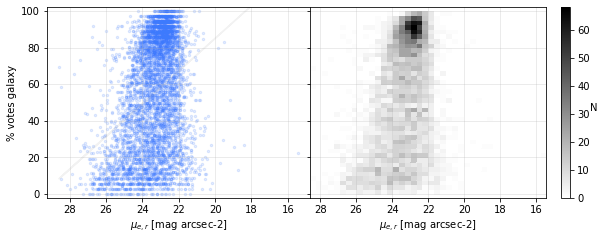

In [55]:
fig, fr = plt.subplots(1,2, figsize=(10,3.5), gridspec_kw=dict(wspace=0, hspace=0, width_ratios=[4,4.5]))

t = df_votes.query('~mue_r.isnull()')

kw = dict(
#     c=t['T0 % galaxy'],
    c='xkcd:lightish blue',
    s=6,
    alpha=0.15
)

sc = fr[0].scatter(t['mue_r'], t['T0 % galaxy'], **kw)
h2d = fr[1].hist2d(t['mue_r'], t['T0 % galaxy'], bins=(40), cmap='binary')
p, res, _, _, _ = np.polyfit(t['mue_r'], t['T0 % galaxy'], 1, full=True)
ys = np.polyval(p, t['mue_r'])
fr[0].plot(t['mue_r'], ys, c='grey', alpha=0.1)

cb = fig.colorbar(h2d[3])
cb.set_label('N', rotation=0)

fr[0].grid(alpha=0.3)
fr[0].set_ylabel("% votes galaxy", )
fr[1].grid(alpha=0.3)
fr[1].set_yticklabels([])

for i in range(2):
    fr[i].update(dict(ylim=[-2,102], xlabel=r"$\mu_{e,r}$ [mag arcsec-2]"))
    fr[i].invert_xaxis()

# cb = fig.colorbar(sc)
# cb.set_label("% votes galaxy", rotation=-90, labelpad=15)

plt.savefig('./plots/ground truth/all objects - surface brightness vs. galaxy vote percentage.png', dpi=200, bbox_inches='tight')

plt.show()

In [56]:
np.corrcoef(t['mue_r'], t['T0 % galaxy'])

array([[ 1.        , -0.33746828],
       [-0.33746828,  1.        ]])

## Fluffy galaxies as per users:

Plot 1:
- Distribution of percent votes for Galaxy (T0) and Fluffy (T1).

Plot 2:
- Plot the cumulative fraction of objects remaining for increasing vote percentage thresholds, for Galaxy (T0) and Fluffy (T1). 
    - In the left subplot, we see that 100% (fraction of 1.0) of objects have at least 0% T0 votes _Galaxy_, and approx. 40% (fraction of 0.4) of objects have at least 60% T0 votes _Galaxy_.
    - In the right subplot, we see that less than 90% (fraction of 0.9) of objects have 10% or more T1 votes for _Fluffy_, and approx. 25% (fraction of 0.25) of objects have 100% of T1 votes for _Fluffy_.
    
Plot 2 is just a different way of visualizing the distributions from plot 1. Plot 1 might be more intuitive.

In [57]:
percentage_pass_gal_threshold = [df_votes.query('`T0 % galaxy` >= @i').shape[0]/df_votes.query('`T0 % galaxy` >= 0').shape[0] for i in range(101)]
percentage_pass_fluffy_threshold = [df_votes.query('`T1 % fluffy` >= @i').shape[0]/df_votes.query('`T1 % fluffy` >= 0').shape[0] for i in range(101)]

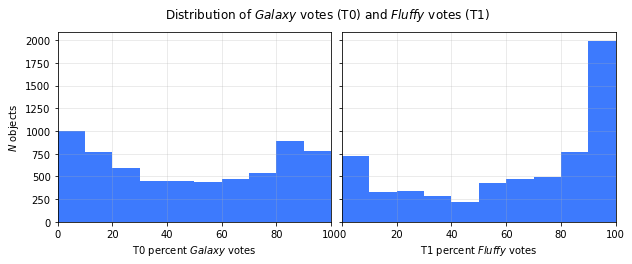

In [58]:
fig, fr = plt.subplots(1,2, figsize=(10,3.5), sharey=True, gridspec_kw=dict(wspace=0.04))

kw = dict(color='xkcd:lightish blue', bins=10)

fr[0].hist(df_votes['T0 % galaxy'], **kw)
fr[1].hist(df_votes['T1 % fluffy'], **kw)

fr[0].update(dict(
    xlabel='T0 percent $Galaxy$ votes',
    ylabel='$N$ objects'
))

fr[1].update(dict(
    xlabel='T1 percent $Fluffy$ votes'
))

for i in range(2):
    fr[i].update(dict(xlim=[0,100]))
    fr[i].grid(alpha=0.3)
    
fig.suptitle('Distribution of $Galaxy$ votes (T0) and $Fluffy$ votes (T1)')
plt.show()

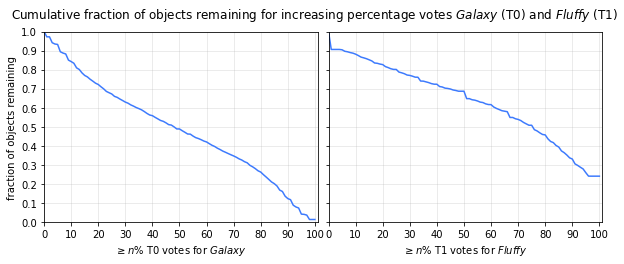

In [59]:
fig, fr = plt.subplots(1,2, figsize=(10,3.5), sharey=True, gridspec_kw=dict(wspace=0.04))

fr[0].plot(list(range(101)), percentage_pass_gal_threshold, c='xkcd:lightish blue')
fr[0].update(dict(
    xlabel='$\geq n\%$ T0 votes for $Galaxy$',
    ylabel='fraction of objects remaining',
    xlim=[0,101],
    ylim=[0,1]
))

fr[1].plot(list(range(101)), percentage_pass_fluffy_threshold, c='xkcd:lightish blue')
fr[1].update(dict(
    xlabel='$\geq n\%$ T1 votes for $Fluffy$',
    xlim=[0,101],
    ylim=[0,1]
))

for i in range(2):
    fr[i].xaxis.set_major_locator(plt.MaxNLocator(11))
    fr[i].yaxis.set_major_locator(plt.MaxNLocator(11))
    fr[i].grid(alpha=0.3)
    
fig.suptitle("Cumulative fraction of objects remaining for increasing percentage votes $Galaxy$ (T0) and $Fluffy$ (T1)")
plt.savefig('./plots/ground truth/all - fraction galaxy vs threshold.png', dpi=200)

## Parameters of objects the users classify as fluffy galaxies:

In [60]:
gal50 = df_votes.query('`T0 % galaxy` >= 50')
gal75 = df_votes.query('`T0 % galaxy` >= 75')

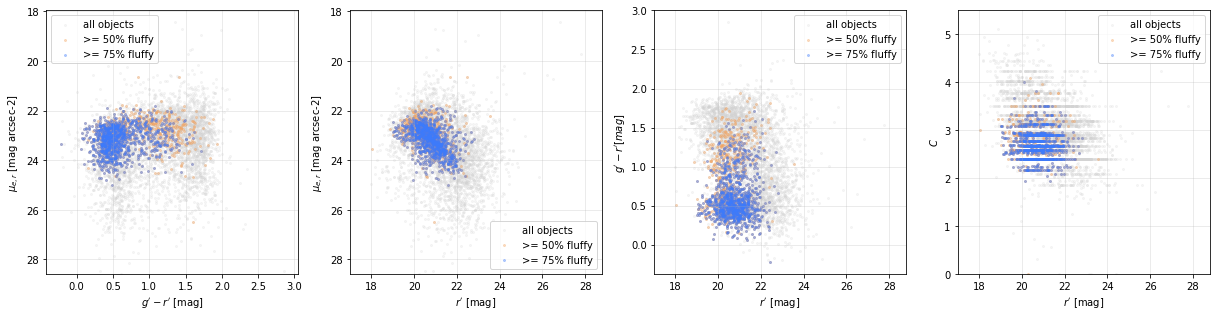

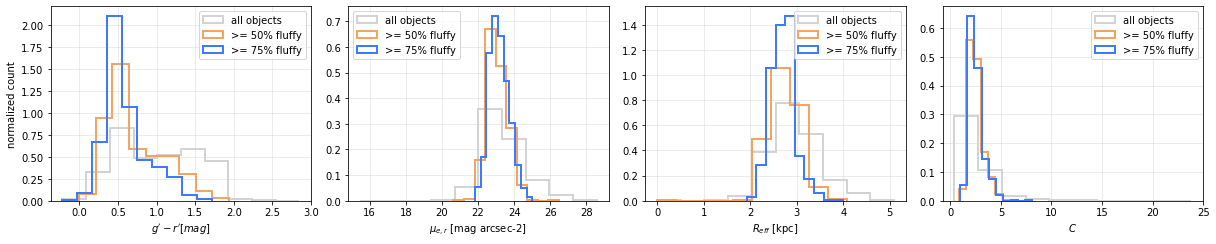

In [61]:
# plot properties of (1) all objects in SF and (2) only the ground truth objects
frames =[
    df_votes.query('C > -1'),
    gal75.query('`T1 % fluffy` >= 50'),
    gal75.query('`T1 % fluffy` >= 75'),
]
labl = [
    'all objects',
    '>= 50% fluffy',
    '>= 75% fluffy' 
]
c = ['lightgrey', 'sandybrown', 'xkcd:lightish blue']

kw = dict(colors=c, alphas=[0.18, 0.35, 0.35], sizes=[4, 4, 4])
plot_phot(frames, labl, **kw, savepath='./plots/ground truth/fluffy - props.png')
plot_distr(frames, labl, colors=c, savepath='./plots/ground truth/fluffy - hist.png')

### Numbers to accompany above plots:

In [62]:
t = df_votes.query('~RA.isnull() & ~r.isnull() & ~g.isnull()')
N = t.shape[0]
print(t.query('g-r >= 1.0').shape[0]/N)

fluf = gal75.query('~RA.isnull() & ~g.isnull() & ~r.isnull() & `T1 % fluffy` >= 75')
print(fluf.query('g-r >= 1.0').shape[0]/fluf.shape[0])

0.4889705882352941
0.12285714285714286


In [63]:
print(t.query('mue_r >= 24').shape[0]/N)
print(fluf.query('mue_r >= 24').shape[0]/fluf.shape[0])

0.25073529411764706
0.08095238095238096


## Cumulative fraction of objects remaining (fluffy subset, all object, LGT objects):
- Alternative to histograms, perhaps does a better job of displaying the range (in parameter space) in which most objects reside in various subsets.

In [64]:
fluf_color_threshold = []
all_color_threshold = []
catalogue_color_threshold = []

colors = np.linspace(np.min(t['g']-t['r']), 2.5, int(5e2))

for i in colors:
    fluf_color_threshold.append(
        fluf.query('g-r >= @i').shape[0]/fluf.shape[0]
    )
    
    all_color_threshold.append(
        t.query('g-r >= @i').shape[0]/N
    )
    
    catalogue_color_threshold.append(
        incatalogue.query('g-r >= @i').shape[0]/incatalogue.shape[0]
    )

In [65]:
fluf_mu_threshold = []
all_mu_threshold = []
catalogue_mu_threshold = []

mus = np.linspace(df_votes['mue_r'].min(), df_votes['mue_r'].max(), int(5e2))

for i in mus:
    fluf_mu_threshold.append(
        fluf.query('mue_r >= @i').shape[0]/fluf.shape[0]
    )
    
    all_mu_threshold.append(
        t.query('mue_r >= @i').shape[0]/N
    )
    
    catalogue_mu_threshold.append(
        incatalogue.query('mue_r >= @i').shape[0]/incatalogue.shape[0]
    )

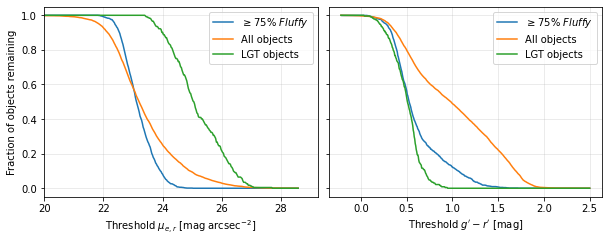

In [66]:
fig, fr = plt.subplots(1,2, figsize=(10,3.5), sharey=True, gridspec_kw=dict(wspace=0.04))

mu_thresholds = [fluf_mu_threshold, all_mu_threshold, catalogue_mu_threshold]
color_thresholds = [fluf_color_threshold, all_color_threshold, catalogue_color_threshold]
labels = [r'$\geq 75\%$ $Fluffy$', 'All objects', 'LGT objects']

for i in range(3):
    fr[0].plot(mus, mu_thresholds[i], label=labels[i])

for i in range(3):
    fr[1].plot(colors, color_thresholds[i], label=labels[i])

fr[1].update(dict(xlabel='Threshold $g\'-r\'$ [mag]'))

for i in range(2):
    fr[i].legend()
    fr[i].grid(alpha=0.3)
    
fr[0].update(dict(
    xlim=(20),
    xlabel=r'Threshold $\mu_{e,r}$ [mag arcsec$^{-2}$]',
))

fr[0].update(dict(xlim=(20), ylabel='Fraction of objects remaining'))

plt.savefig('./plots/ground truth/props cumulative.png', dpi=200, bbox_inches='tight')
plt.show()

## Thresholds

In [67]:
df_votes['vote_count'].mean()

35.06114429424709

In [68]:
from math import comb

n = 34
p = 0.5
k = 17

def binom(n, p, k):
    return comb(n, k)*p**k*(1-p)**(n-k)

In [69]:
t75 = int(0.75*34)+1
t50 = 17

int(t75)

26

In [70]:
100*np.sum([binom(n, p, k) for k in range(t75, n+1)])

0.14675278216600418

### Fluffy, catalogue

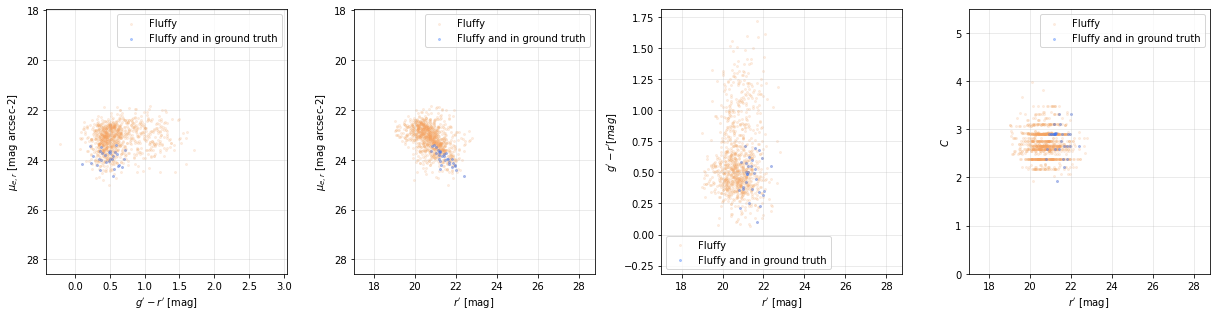

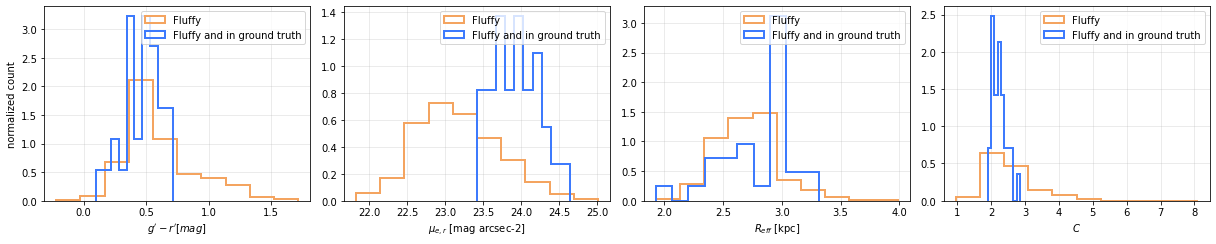

In [71]:
fluf_cat = fluf.query('name.isin(@catalogue_targets)')

# plot properties of (1) all objects in SF and (2) only the ground truth objects
frames = [
    fluf,
    fluf_cat
]
labl = [
    'Fluffy',
    'Fluffy and in ground truth'
]
c = ['sandybrown', 'xkcd:lightish blue']

kw = dict(colors=c, alphas=[0.15, 0.35], sizes=[ 4, 4])
plot_phot(frames, labl, **kw)
plot_distr(frames, labl, colors=c)

In [72]:
def extent(lst):
    lst = np.array(lst)
    return np.min(lst), np.max(lst)

In [73]:
cat_mu_extent = extent(incatalogue['mue_r'])

q = extent(fluf['mue_r'])[1]
incatalogue.query('mue_r <= @q').shape[0]/incatalogue.shape[0]

0.4827586206896552

#### Likely ground truth range of $\mu_{e,r}$:

In [74]:
print(cat_mu_extent)

(23.4209060669, 27.6912975311)


#### Fraction of objects voted _Fluffy_ by the users that are brighter than the brightest LGT object:

In [75]:
fluf.query('mue_r <= @cat_mu_extent[0]').shape[0]/fluf.shape[0]

0.6904761904761905

In [76]:
ns = df_votes['name'].tolist()
object_info.query('name.isin(@ns)').shape[0], object_info.shape[0]

(5440, 6036)

### Objects without properties

In [77]:
object_info = pd.read_csv('../../catalogue/sf_spacefluff_object_data.csv', comment="#")
ns = df_votes['name'].tolist()
object_info.query('name.isin(@ns)').shape[0], object_info.shape[0]

(5440, 6036)

In [78]:
no_props = df_votes.query('RA.isnull()')

In [79]:
t9cols = get_column_names('T9', no_props)
t9cols

['T9',
 'T9 % something else',
 'T9 % looks like a small star',
 'T9 % scattered light',
 'T9 % nothing: background too bright or galaxy too faint']

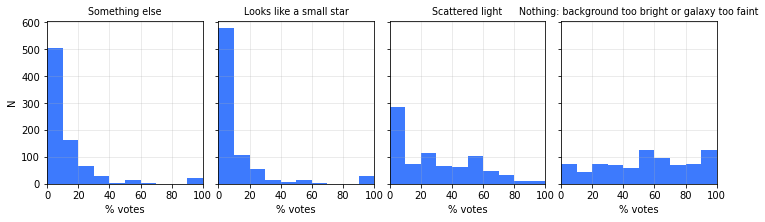

In [80]:
no_props[t9cols[1:]]

fig, fr = plt.subplots(1, len(t9cols[1:]), figsize=(12, 3), sharey=True, gridspec_kw=dict(wspace=0.1))

for i in range(len(fr)):
    col = t9cols[1:][i]
    fr[i].hist(no_props[col], color='xkcd:lightish blue')
    fr[i].set_title("{}".format(col[5:].capitalize()), fontsize=9.5)
    fr[i].grid(alpha=0.3)
    fr[i].set_xlim([0,100])
    fr[i].set_xlabel('% votes')
fr[0].update(dict(ylabel='N'))

plt.savefig('./plots/no props/t9 distributions.png', dpi=200, bbox_inches='tight')
plt.show()

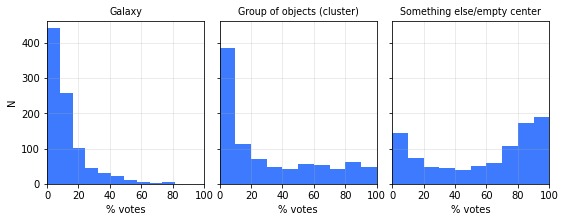

In [81]:
fig, fr = plt.subplots(1, len(t0cols[1:]), figsize=(9, 3), sharey=True, gridspec_kw=dict(wspace=0.1))

for i in range(len(fr)):
    col = t0cols[1:][i]
    fr[i].hist(no_props[col], color='xkcd:lightish blue')
    fr[i].set_title("{}".format(col[5:].capitalize()), fontsize=9.5)
    fr[i].grid(alpha=0.3)
    fr[i].set_xlim([0,100])
    fr[i].set_xlabel('% votes')
fr[0].update(dict(ylabel='N'))

plt.savefig('./plots/no props/t0 distributions.png', dpi=200, bbox_inches='tight')
plt.show()

In [82]:
has_props = df_votes.query('~RA.isnull()')

In [83]:
# @todo: synchronize xlim and ylim based on min and max of whole dataframe
def params_vs_votes(answers, savepath=None):
    for idx, ans in enumerate(answers):
        fig, fr = plt.subplots(1,4, figsize=(13, 3), gridspec_kw=dict(wspace=0.3, width_ratios=[4,4,4,5]))

        r, g, mue_r, C = get_cols(has_props, ['r', 'g', 'mue_r', 'C'])

        kw = dict(s=2, alpha=0.2, c = has_props[ans])

        sc = fr[0].scatter(g-r, mue_r, **kw)
        fr[1].scatter(r, mue_r, **kw)
        fr[2].scatter(r, g-r, **kw)
        fr[3].scatter(r, C, **kw)

        cb = fig.colorbar(sc)
        cb.set_label('% {}'.format(ans[5:]), rotation=-90, fontsize=12, labelpad=15)

        fr[3].update(dict(
            ylim=(0, np.max(df_votes['C'])+0.4)
        ))

        fr[0].set_xlabel(r"$g'-r'$ [mag]")
        fr[0].set_xlim([np.min(df_votes['g']-df_votes['r'])-0.2, np.max(df_votes['g']-df_votes['r'])+0.2])

        for i in range(2):
            fr[i].set_ylim(np.min(df_votes['mue_r'])+2.5, np.max(df_votes['mue_r']))
            fr[i].set_ylabel(r'$\mu_{e,r}$ [mag arcsec-2]')
            fr[i].set_ylim(fr[i].get_ylim()[::-1])

        for i in range(1, 4):
            fr[i].set_xlabel(r"$r'$ [mag]")
            fr[i].set_xlim(np.min(df_votes['r'])-1, np.max(df_votes['r'])+1)

        fr[2].set_ylabel(r"$g'-r' [mag]$")
        fr[3].set_ylabel('$C$')

        for i in range(4):
            fr[i].grid(alpha=0.3, which='both')
            fr[i].xaxis.labelpad=-3
            fr[i].yaxis.labelpad=-2
            fr[i].xaxis.label.set_size(13)
            fr[i].yaxis.label.set_size(13)

        if savepath:
            plt.savefig('{}-{}.png'.format(savepath, idx), dpi=200, bbox_inches='tight')
    plt.show()

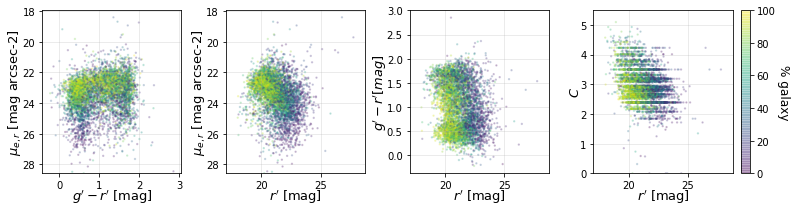

In [84]:
params_vs_votes(t0cols[1:2], savepath="./plots/tasks/t0")

[[ 1.        -0.5308674]
 [-0.5308674  1.       ]]


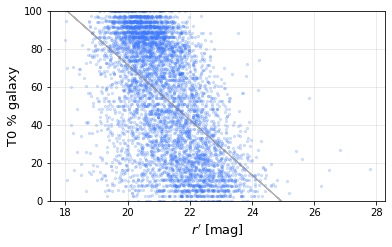

In [168]:
fig, fr = plt.subplots(figsize=(6,3.5))

d = df_votes.query('~r.isnull()')
x, y = d['r'], d['T0 % galaxy']
fr.scatter(x, y, s=5, alpha=0.2, c='xkcd:lightish blue')
print(np.corrcoef(x, y))

p = np.polyfit(x, y, 1)
y = np.polyval(p, x)
fr.plot(x, y, c='grey', lw=1, alpha=0.6)
fr.grid(alpha=0.3)

fr.update(dict(
    ylim=[0,100], 
))

fr.set_xlabel("$r'$ [mag]", fontsize=13)
fr.set_ylabel('T0 % galaxy', fontsize=13)

plt.savefig('./plots/tasks/r vs t0 galaxy')
plt.show()


In [85]:
# fig, fr = plt.subplots(figsize=(5,5))
# fields = get_cols(has_props, ['r', 'T0 % galaxy'])
# fr.hist2d(*fields, bins=40)
# # fr.scatter(*get_cols(has_props.query('r < 22.5'), ['r', 'T0 % galaxy']))
# fr.update(dict(xlabel=r"$r'$ [mag]", ylabel=r"% galaxy"))

# plt.show()

# print(np.corrcoef(*fields))

# fig, fr = plt.subplots(figsize=(5,5))
# fields = get_cols(has_props, ['mue_r', 'T0 % galaxy'])
# fr.hist2d(*fields, bins=40)
# # fr.scatter(*get_cols(has_props.query('r < 22.5'), ['r', 'T0 % galaxy']))
# fr.update(dict(xlabel=r"$r'$ [mag]", ylabel=r"% galaxy"))

# plt.show()

# print(np.corrcoef(*fields))

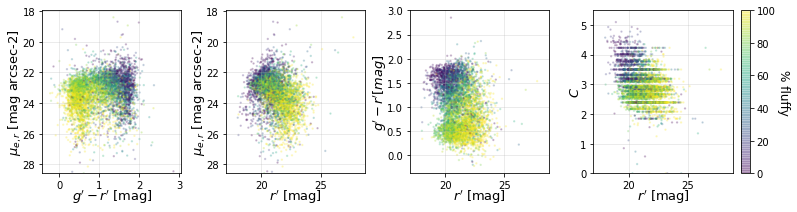

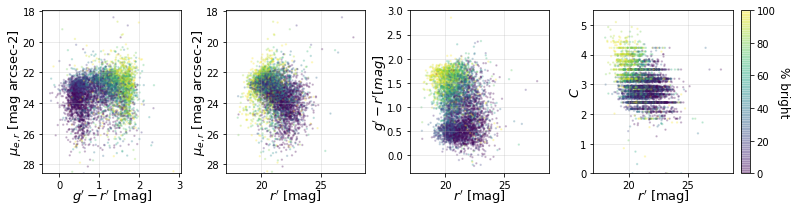

In [86]:
params_vs_votes(t1cols[1:], savepath="./plots/tasks/t1")

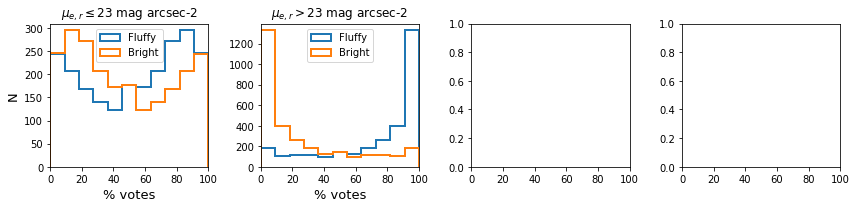

In [87]:
kw = dict(histtype='step', facecolor='none', lw=2, bins=11)

fig, fr = plt.subplots(1,4, figsize=(12,3))

labels = [
    '$\mu_{e,r} \leq 23$ mag arcsec-2',
    '$\mu_{e,r} > 23$ mag arcsec-2',
#     '$22 < \mu_{e,r} < 25$ mag arcsec-2',
#     'All objects'
]

for i, df in enumerate([
    has_props.query('mue_r <= 23'),
    has_props.query('mue_r > 23'),
#     has_props.query('mue_r < 25 & mue_r > 22'),
#     has_props
]):
    fr[i].hist(df['T1 % fluffy'], **kw, label="Fluffy")
    fr[i].hist(df['T1 % bright'], **kw, label="Bright")

    for i in range(4):
        fr[i].grid(alpha=0.3)
        fr[i].update(dict(xlim=[0,100]))

for i in range(len(labels)):
    fr[i].set_title(labels[i])
    fr[i].legend(loc='upper center')
    fr[i].set_xlabel('% votes')
    fr[i].xaxis.label.set_size(13)
    fr[i].yaxis.label.set_size(13)
    
fr[0].set_ylabel('N')

fig.tight_layout()

# plt.savefig('./plots/tasks/t1 vs surface brightness.png', dpi=200, bbox_inches='tight')
plt.show()

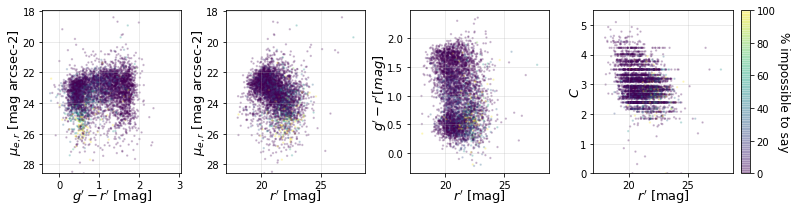

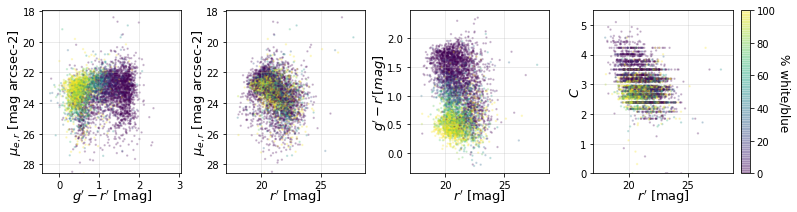

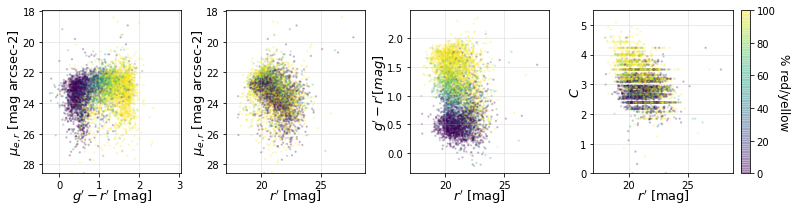

In [88]:
params_vs_votes(t2cols[1:], savepath="./plots/tasks/t2")

In [89]:
def fit_color(r, g, votes, deg=1):
    idx = np.where(~np.isnan(r) & ~np.isnan(g) & ~np.isnan(votes))

    _g = g[idx]
    _r = r[idx]
    _votes = votes[idx]

    xs = np.linspace(np.min(_g-_r), np.max(_g-_r), int(1e4))

    # build polynomial factors, sum them to get each value of y
    p = np.polyfit(_g-_r, _votes, deg)[::-1]
    ys = sum([p[i]*xs**i for i in range(len(p))])
    
    return xs, ys

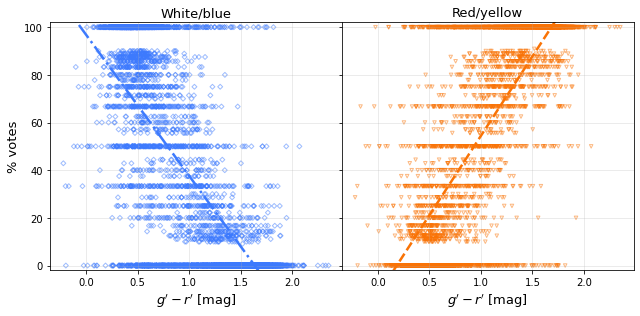

In [90]:
g, r, w_b, r_y = get_cols(has_props[has_props['T2'].apply(lambda x: sum(x.values()) > 0)], ['g', 'r', *t2cols[2:]])

fig, fr = plt.subplots(1,2, figsize=(9,4.5), sharey=True, gridspec_kw=dict(wspace=0))

kwargs = { "alpha": 0.5, "s": 12, "facecolor": "none" }

fr[0].scatter(g-r, w_b, **kwargs, marker="D", edgecolor="xkcd:lightish blue", label="data")
fr[0].plot(*fit_color(r, g, w_b), c='xkcd:lightish blue', lw=2.5, ls='-.', label="linear fit")

fr[1].scatter(g-r, r_y, **kwargs, marker="v", edgecolor="xkcd:orange", label="data")
fr[1].plot(*fit_color(r, g, r_y), c='xkcd:orange', lw=2.5, ls='--', label="linear fit")

for i in range(2):
    fr[i].set_xlabel(r"$g'-r'$ [mag]")

    fr[i].grid(alpha=0.3, which='both')
#     fr[i].legend()
    fr[i].xaxis.label.set_size(13)
    fr[i].yaxis.label.set_size(13)
    
fr[0].set_title('White/blue', fontsize=13)
fr[1].set_title('Red/yellow', fontsize=13)
fr[0].set_ylim(-2, 102)
fr[0].set_ylabel('% votes')

fig.tight_layout()
plt.savefig('./plots/tasks/color vs votes.png', dpi=200, bbox_inches='tight')

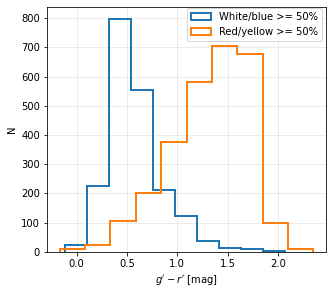

In [91]:

fig, fr = plt.subplots(figsize=(5,4.5))

kw = dict(histtype='step', lw=2, facecolor='none')

t = has_props.query('`T2 % white/blue` >= 50')
fr.hist(t['g']-t['r'], **kw, label="White/blue >= 50%")

t = has_props.query('`T2 % red/yellow` >= 50')
fr.hist(t['g']-t['r'], **kw, label='Red/yellow >= 50%')

fr.update(dict(xlabel=r"$g'-r'$ [mag]", ylabel='N'))
fr.legend(loc=(0.5,0.86))
fr.grid(alpha=0.3)

plt.savefig('./plots/tasks/color vs votes histogram.png', dpi=200, bbox_inches='tight')

In [216]:
for name, row in df_votes.query('g-r < 0.5 & `T2 % red/yellow` > 50').iterrows():
    if sum(row['T2'].values()) > 5:
        print(row['name'], row['T2'], row['g']-row['r'])

UDGcand_6835 {'Red/yellow': 6} 0.3293399810999986
UDGcand_4301 {'Red/yellow': 4, 'White/blue': 3} 0.4405288696999996
UDGcand_4238 {'Red/yellow': 6} 0.3457946777000025


In [215]:
weird_color = ['UDGcand_6835', 'UDGcand_4301', 'UDGcand_4238']

# plot_image_grid(df_votes.query('name.isin(@weird_color)'), 1, 3, savepath='./plots/weird_color')

In [92]:
t = has_props[has_props['T2'].apply(lambda x: sum(x.values()) > 5)]
# t = has_props.query('~T2.isnull()')
np.corrcoef(t['g']-t['r'], t['T2 % white/blue']), np.corrcoef(t['g']-t['r'], t['T2 % red/yellow'])

(array([[ 1.       , -0.8707397],
        [-0.8707397,  1.       ]]),
 array([[1.        , 0.89103519],
        [0.89103519, 1.        ]]))

In [93]:
kw = dict(alpha=0.3, s=4, marker='D', c='xkcd:lightish blue')

color vs % fluffy
 [[ 1.         -0.75656354]
 [-0.75656354  1.        ]]
surface brightness vs %fluffy
 [[1.         0.29278875]
 [0.29278875 1.        ]]



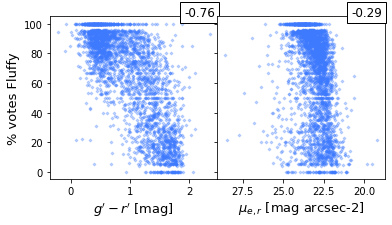

In [94]:
t = has_props.query('`T0 % galaxy` >= 50')
t = t[t['T1'].apply(lambda x: sum(x.values())) > 1]

for ans in ['fluffy']:
    fig, fr = plt.subplots(1, 2, figsize=(6,3), sharey=True, gridspec_kw=dict(wspace=0.0))
    x, y = t['g']-t['r'], t['T1 % {}'.format(ans)]
    print('color vs % {}\n'.format(ans), np.corrcoef(x, y))
    fr[0].scatter(x, y, **kw)
    fr[0].update(dict(xlabel='$g\'-r\'$ [mag]', ylabel="% votes {}".format(ans.capitalize())))
    fr[0].text(
        s='{}'.format(round(np.corrcoef(x, y)[0,1],2)), x=0.8,y=1, transform=fr[0].transAxes,
        bbox=dict(facecolor='white', edgecolor='black'),
        fontsize=12,
        zorder=101
    )
    
    x = t['mue_r']
    print('surface brightness vs %{}\n'.format(ans), np.corrcoef(x, y))
    fr[1].scatter(x, y, **kw, zorder=10)
    fr[1].update(dict(xlabel=r"$\mu_{e,r}$ [mag arcsec-2]"))
    fr[1].invert_xaxis()
    fr[1].text(
        s='{}'.format(round(np.corrcoef(-x, y)[0,1],2)), x=0.8,y=1, transform=fr[1].transAxes,
        bbox=dict(facecolor='white', edgecolor='black'),
        fontsize=12
    )
    print('')
    
    for i in range(2):
        fr[i].xaxis.label.set_size(13)
        fr[i].yaxis.label.set_size(13)
    
    plt.savefig('./plots/tasks/fluffy vs color and surface brightness.png', dpi=200, bbox_inches='tight')

color vs % galaxy
 [[ 1.         -0.12903227]
 [-0.12903227  1.        ]]
surface brightness vs %galaxy
 [[ 1.         -0.33746828]
 [-0.33746828  1.        ]]

concentration vs %galaxy
 [[1.         0.03288246]
 [0.03288246 1.        ]]


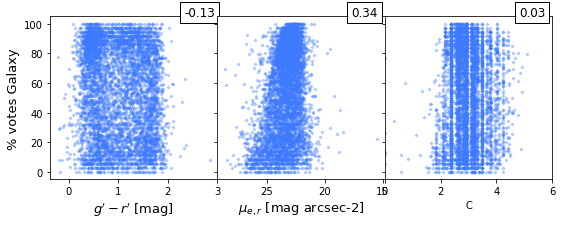

In [95]:
t = has_props #.query('`T0 % galaxy` >= 50')
t = t[t['T0'].apply(lambda x: sum(x.values())) > 1]

for ans in ['galaxy']:
    fig, fr = plt.subplots(1, 3, figsize=(9,3), sharey=True, gridspec_kw=dict(wspace=0.0))
    x, y = t['g']-t['r'], t['T0 % {}'.format(ans)]
    print('color vs % {}\n'.format(ans), np.corrcoef(x, y))
    fr[0].scatter(x, y, **kw)
    fr[0].update(dict(xlabel='$g\'-r\'$ [mag]', ylabel="% votes {}".format(ans.capitalize())))
    fr[0].text(
        s='{}'.format(round(np.corrcoef(x, y)[0,1],2)), x=0.8,y=1, transform=fr[0].transAxes,
        bbox=dict(facecolor='white', edgecolor='black'),
        fontsize=12,
        zorder=101
    )
    
    x = t['mue_r']
    print('surface brightness vs %{}\n'.format(ans), np.corrcoef(x, y))
    fr[1].scatter(x, y, **kw, zorder=10)
    fr[1].update(dict(xlabel=r"$\mu_{e,r}$ [mag arcsec-2]"))
    fr[1].invert_xaxis()
    fr[1].text(
        s='{}'.format(round(np.corrcoef(-x, y)[0,1],2)), x=0.8,y=1, transform=fr[1].transAxes,
        bbox=dict(facecolor='white', edgecolor='black'),
        fontsize=12
    )
    print('')
    
    x = t['C']
    print('concentration vs %{}\n'.format(ans), np.corrcoef(x, y))
    fr[2].scatter(x, y, **kw)
    fr[2].update(dict(xlim=[0,6], xlabel='C'))
    fr[2].text(
        s='{}'.format(round(np.corrcoef(x, y)[0,1],2)), x=0.8,y=1, transform=fr[2].transAxes,
        bbox=dict(facecolor='white', edgecolor='black'),
        fontsize=12
    )
    
    for i in range(2):
        fr[i].xaxis.label.set_size(13)
        fr[i].yaxis.label.set_size(13)
    
    plt.savefig('./plots/tasks/galaxy vs props.png', dpi=200, bbox_inches='tight')

color vs % red/yellow
 [[1.         0.83190707]
 [0.83190707 1.        ]]
surface brightness vs %red/yellow
 [[ 1.         -0.05369287]
 [-0.05369287  1.        ]]

concentration vs %red/yellow
 [[1.         0.12565051]
 [0.12565051 1.        ]]


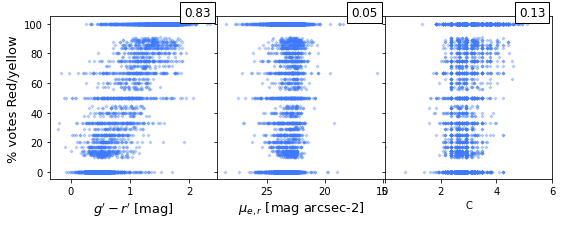

In [96]:
t = has_props #.query('`T0 % galaxy` >= 50')
t = t[t['T2'].apply(lambda x: sum(x.values())) > 1]

for ans in ['red/yellow']:
    fig, fr = plt.subplots(1, 3, figsize=(9,3), sharey=True, gridspec_kw=dict(wspace=0.0))
    x, y = t['g']-t['r'], t['T2 % {}'.format(ans)]
    print('color vs % {}\n'.format(ans), np.corrcoef(x, y))
    fr[0].scatter(x, y, **kw)
    fr[0].update(dict(xlabel='$g\'-r\'$ [mag]', ylabel="% votes {}".format(ans.capitalize())))
    fr[0].text(
        s='{}'.format(round(np.corrcoef(x, y)[0,1],2)), x=0.8,y=1, transform=fr[0].transAxes,
        bbox=dict(facecolor='white', edgecolor='black'),
        fontsize=12,
        zorder=101
    )
    
    x = t['mue_r']
    print('surface brightness vs %{}\n'.format(ans), np.corrcoef(x, y))
    fr[1].scatter(x, y, **kw, zorder=10)
    fr[1].update(dict(xlabel=r"$\mu_{e,r}$ [mag arcsec-2]"))
    fr[1].invert_xaxis()
    fr[1].text(
        s='{}'.format(round(np.corrcoef(-x, y)[0,1],2)), x=0.8,y=1, transform=fr[1].transAxes,
        bbox=dict(facecolor='white', edgecolor='black'),
        fontsize=12
    )
    print('')
    
    x = t['C']
    print('concentration vs %{}\n'.format(ans), np.corrcoef(x, y))
    fr[2].scatter(x, y, **kw)
    fr[2].update(dict(xlim=[0,6], xlabel='C'))
    fr[2].text(
        s='{}'.format(round(np.corrcoef(x, y)[0,1],2)), x=0.8,y=1, transform=fr[2].transAxes,
        bbox=dict(facecolor='white', edgecolor='black'),
        fontsize=12
    )
    
    for i in range(2):
        fr[i].xaxis.label.set_size(13)
        fr[i].yaxis.label.set_size(13)
    
#     plt.savefig('./plots/tasks/t2 color vs props.png', dpi=200, bbox_inches='tight')

(0.9008620689655172, 0.08095238095238096)

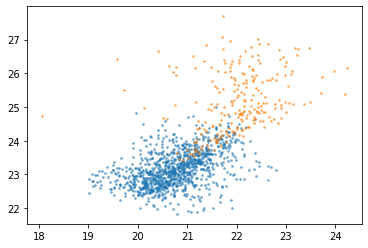

In [97]:
fluf75 = df_votes.query('`T0 % galaxy` >= 75 & `T1 % fluffy` >=75')

fig, fr = plt.subplots()

a = fluf75
b = incatalogue
fr.scatter(a['r'], a['mue_r'], s=3, alpha=0.5)
fr.scatter(b['r'], b['mue_r'], s=3, alpha=0.5)

incatalogue.query('mue_r >= 24').shape[0]/incatalogue.shape[0], fluf75.query('mue_r >= 24').shape[0]/fluf75.shape[0]



^ 

~90% of likely ground truth objects have surface brightness of at least 24 mag/arcsec2, but objects classified as fluffy galaxies are only this faint ~8% of the time.

In [98]:
get_column_names('T9', df_votes)[4]

'T9 % nothing: background too bright or galaxy too faint'

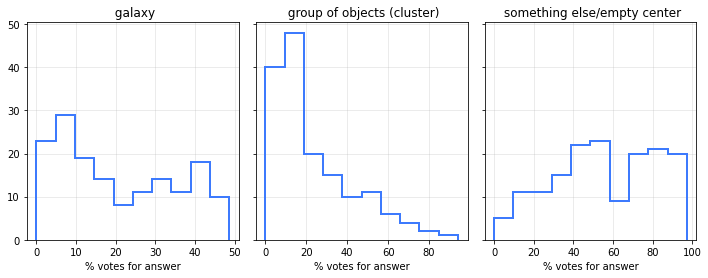

In [99]:
fig, fr = plt.subplots(1, 3, figsize=(12,4), sharey=True, gridspec_kw=dict(wspace=0.08))

for i, col in enumerate(t0cols[1:]):
    fr[i].hist(df_votes.query('name.isin(@catalogue_targets) & `T0 % galaxy` < 50')[col], color='xkcd:lightish blue', histtype='step', lw=2)
    fr[i].update(dict(title=col[4:], xlabel='% votes for answer'))
    fr[i].grid(alpha=0.3)

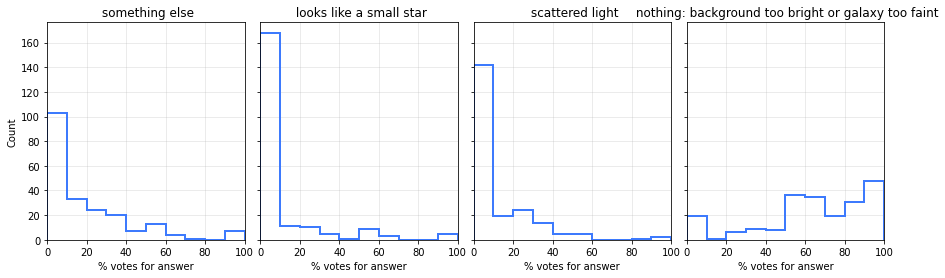

In [100]:
fig, fr = plt.subplots(1,4, figsize=(15,4), sharey=True, gridspec_kw=dict(wspace=0.08))

for idx, col in enumerate(get_column_names('T9', df_votes)[1:]):
    t9vals = []
    for i, row in df_votes.query('name.isin(@catalogue_targets)').iterrows():
        t9vals.append(row.get(col, None))
    
    fr[idx].hist(np.array(t9vals)[~np.isnan(np.array(t9vals))], histtype='step', lw=2, density=0,  color='xkcd:lightish blue')
    fr[idx].update(dict(title=col[4:], xlim=[0,100], xlabel='% votes for answer'))
    fr[idx].grid(alpha=0.3)
    fr[0].update(dict(ylabel='Count'))